# Graph of the teams

First, to display our data, we can show a graph made with all marvel 616 universe, where two teams are connected if they share at least one member.

In [27]:
import pandas as pd

import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

import ast

from itertools import combinations

from tqdm.notebook import tqdm

from fa2 import ForceAtlas2

import random

import seaborn as sns
sns.set()

import nltk

import re

import math

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import utils

In [2]:
df = pd.read_csv("../data/marvel_teams.csv")

df["members"] = df["members"].apply(ast.literal_eval)

df.head()

team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...  
1                                                 []  
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...  
3                                                 []  
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...

With this dataframe, we can get all characters that are members of one team at list.

In [3]:
characters = list(set(df["members"].sum()))
characters[:5]

['Denga Bautista (Earth-616)',
 'José Accardo (Earth-616)',
 'File:Charlie (Earth-616) from Avengers Annual Vol 1 1 0001.jpg',
 'Ted Halsey (Earth-616)',
 'Charles Snow (Earth-616)']

In [4]:
len(characters)

12298

In [5]:
def getTeams(character, df):
  teams = list(df[df.apply(lambda x: character in x["members"], axis=1)]["team_name"])
  return list(combinations(teams, 2))

Now it is time to create the graph :).

Each node is going to be a team, and a link will reflect that they have one memberr in common at least

In [6]:
team_combinations = []

for character in tqdm(characters):
  team_comb = getTeams(character, df)
  if len(team_comb):
    team_combinations += team_comb

team_combinations[:5]

  0%|          | 0/12298 [00:00<?, ?it/s]

[('50-State Initiative (Earth-616)',
  'Underground (Secret Empire) (Earth-616)'),
 ('50-State Initiative (Earth-616)', 'Project P.E.G.A.S.U.S. (Earth-616)'),
 ('Underground (Secret Empire) (Earth-616)',
  'Project P.E.G.A.S.U.S. (Earth-616)'),
 ('Fatboys (Earth-616)', 'Bratpack (Earth-616)'),
 ('Parker Industries (Earth-616)', 'Fist (Earth-616)')]

In [7]:
G = nx.Graph()

G.add_nodes_from(list(df["team_name"]))

G.add_edges_from(team_combinations)

len(G.nodes()), len(G.edges())

(3051, 15009)

In [8]:
GCC = G.subgraph(max(nx.connected_components(G), key=len))

len(GCC.nodes()), len(GCC.edges())

(1381, 14917)

In [9]:
sum([x[1] for x in GCC.degree])/len(GCC.nodes)

21.603186097031138

Now, let's draw our network

In [10]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(GCC, pos=None, iterations=200)

100%|█████████████████████████████████████████| 200/200 [01:59<00:00,  1.67it/s]

BarnesHut Approximation  took  4.76  seconds
Repulsion forces  took  108.09  seconds
Gravitational forces  took  0.28  seconds
Attraction forces  took  5.55  seconds
AdjustSpeedAndApplyForces step  took  0.84  seconds


In [11]:
sizes = []
alphas = []
colors = []
max_degree = max(GCC.degree(), key=lambda x: x[1])[1]

for node in tqdm(GCC.nodes):
  size = GCC.degree(node) * 25 + 100
  alpha = max([GCC.degree(node)/max_degree, .2])
  
  colors.append((random.random(), random.random(), random.random()))
  
  sizes.append(size)
  alphas.append(alpha)

  0%|          | 0/1381 [00:00<?, ?it/s]

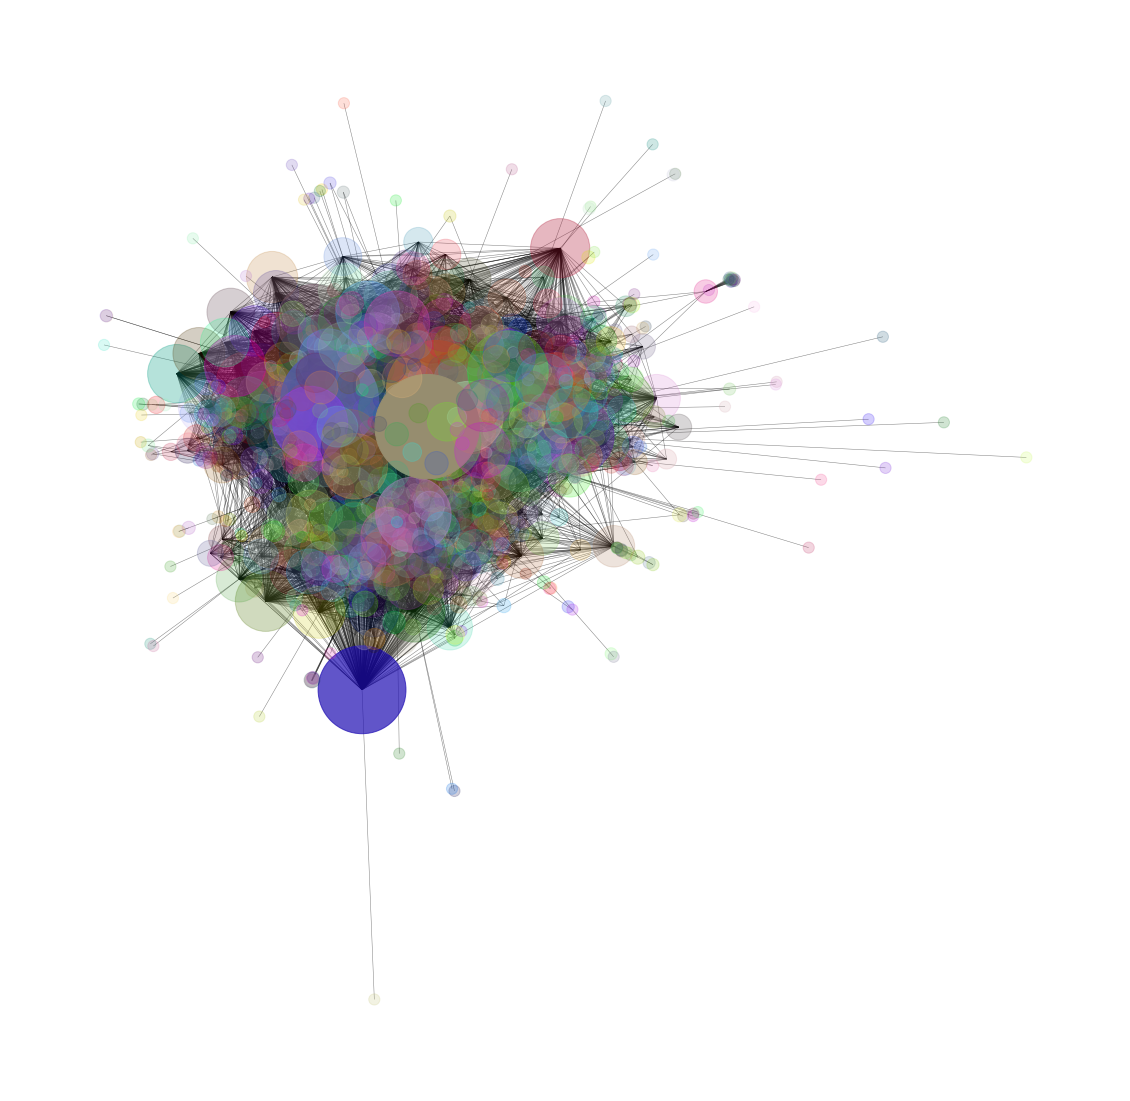

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))

nx.draw_networkx_nodes(GCC,
                       positions,
                       linewidths  = 1,
                       node_size   = sizes,
                       node_color  = colors,
                       alpha       = alphas,
                       ax          = ax
                      )

nx.draw_networkx_edges(GCC,
                       positions,
                       edge_color  = "black",
                       arrowstyle  = "-",
                       alpha       = 0.5,
                       width       = .5,
                       ax          = ax
                      )  
plt.axis("off")

plt.show()

In [13]:
sorted_teams = sorted(GCC.degree, key=lambda x: x[1], reverse=True)

sorted_teams[:10]

[('Strategic Homeland Intervention, Enforcement and Logistics Division (Earth-616)',
  432),
 ('50-State Initiative (Earth-616)', 383),
 ('Avengers (Earth-616)', 378),
 ('X-Men (Earth-616)', 305),
 ('Thunderbolts (Earth-616)', 256),
 ('United States Army (Earth-616)', 231),
 ('Hydra (Earth-616)', 229),
 ('Hellfire Club (Earth-616)', 224),
 ('Defenders (Earth-616)', 221),
 ('Secret Defenders (Earth-616)', 214)]

In [14]:
# most members

df["number_members"] = df["members"].apply(lambda x: len(x))

df.sort_values("number_members", ascending=False)

team_name  \
2879  Strategic Homeland Intervention, Enforcement a...   
690         New York City Police Department (Earth-616)   
3025  National Socialist German Workers Party (Earth...   
566                      United States Army (Earth-616)   
1163                                  Hydra (Earth-616)   
...                                                 ...   
803                           Chicken Hawks (Earth-616)   
2099                Walking Dead (Japanese) (Earth-616)   
2095                        Impossible Kids (Earth-616)   
808           Victor Creed Clones (Romulus) (Earth-616)   
1525                                  Choir (Earth-616)   

                                                members  number_members  
2879  [Abigail Brand (Earth-616), Abner Jenkins (Ear...             640  
690   [Al Farrell (Earth-616), Alan Greene (Earth-61...             577  
3025  [Admiral von Roeder (Earth-616), Adolf Hitler ...             405  
566   [101st Airborne Division (Earth-616), 82nd Air...             395  
1163  [Aaron Nicholson (Earth-616), Adi (Earth-616),...             282  
...                                                 ...             ...  
803                                                  []               0  
2099                                                 []               0  
2095                                                 []               0  
808                                                  []               0  
1525                                                 []               0  

[3051 rows x 3 columns]

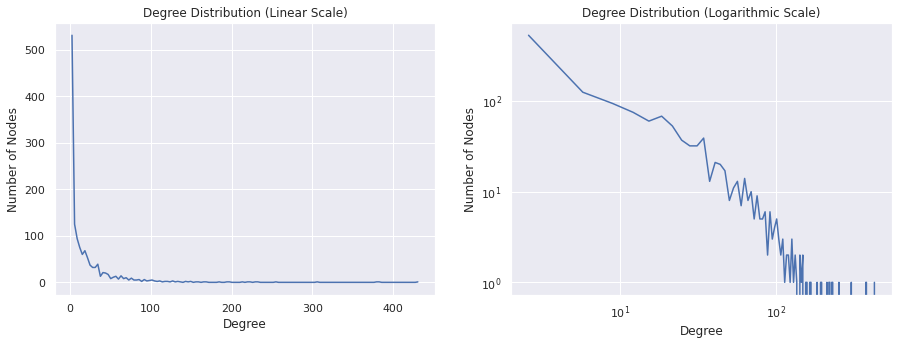

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

hist, bins = np.histogram(np.array(GCC.degree())[:, 1].astype(np.int), bins=135)

center = (bins[:-1] + bins[1:])/2

ax1.plot(center, hist)
ax1.set_title("Degree Distribution (Linear Scale)")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Number of Nodes")

ax2.plot(center, hist)
ax2.set_title("Degree Distribution (Logarithmic Scale)")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel("Degree")
ax2.set_ylabel("Number of Nodes")
plt.show()

As there appears to be a lot of nodes with low degree, while only a few have a high degree, we can say that this network is not random as it follows a power-law distribution.

## Quotes

Let's do a list of text per team with the quotes of all their characters

In [16]:
tqdm.pandas(desc="Getting quotes")

In [17]:
  def getQuotes(row):
    quotes = []
    for member in row["members"]:
      try:
        with open("../data/character_quotes/"+member.replace(" ", "_")+".json") as f:
          quotes += ast.literal_eval(f.read())
      except:
        quotes += []

    return pd.Series([quotes, len(quotes)])


  df[["quotes", "number_quotes"]] = df.progress_apply(getQuotes, axis=1)
  df.head()

Getting quotes:   0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  number_members  \
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                 []               0   
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                 []               0   
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   

                                              quotes  number_quotes  
0  [Now I can take my father's place -- as an Inv...            169  
1                                                 []              0  
2  [There's only two things I ever managed to bel...            922  
3                                                 []              0  
4  [I have defeated the most deadly toros in a th...             26

With the quotes now we can do sentiment analysis

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pheithar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pheithar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
wnl = nltk.WordNetLemmatizer()

def preprocesQuotes(row):
  process_quotes = []
  for quote in row["quotes"]:
    quote = re.sub(r"[^a-zA-Z0-9\s]", " ", quote)
    tokens = tokenizer.tokenize(quote)
    all_words = [x.strip().lower() for x in tokens]
    
    stop_words = list(nltk.corpus.stopwords.words("english")) # Stopwords
    stop_words += ["im", "one"]
    
    filtered = [x for x in all_words if x not in stop_words]
    
    lemmatized = [wnl.lemmatize(w) for w in filtered]
    process_quotes.append(lemmatized)
  
  return process_quotes

df["processed_quotes"] = df.progress_apply(preprocesQuotes, axis=1)
df.head()

Getting quotes:   0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  number_members  \
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                 []               0   
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                 []               0   
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   

                                              quotes  number_quotes  \
0  [Now I can take my father's place -- as an Inv...            169   
1                                                 []              0   
2  [There's only two things I ever managed to bel...            922   
3                                                 []              0   
4  [I have defeated the most deadly toros in a th...             26   

                                    processed_quotes  
0  [[take, father, place, invader], [take, father...  
1                                                 []  
2  [[two, thing, ever, managed, believe, firstly,...  
3                                                 []  
4  [[defeated, deadly, toros, thousand, bull, fig...

In [20]:
def term_frequency(term, document):
  return document.count(term)/len(document)

def inverse_document_frequency(term, documents):  
  return math.log(len(documents) / (1 + sum([term in doc for doc in documents])))

def term_frequency_inverse_document_frequency(term, document, documents):
  return term_frequency(term, document) * inverse_document_frequency(term, documents)

def apply_tfidf(row):
  return list(set([(word, term_frequency_inverse_document_frequency(word, quote, row["processed_quotes"]))
          for quote
          in row["processed_quotes"]
          for word
          in set(quote)]))
  
df["tf-idf"] = df.progress_apply(apply_tfidf, axis=1)
df.head()

Getting quotes:   0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  number_members  \
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                 []               0   
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                 []               0   
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   

                                              quotes  number_quotes  \
0  [Now I can take my father's place -- as an Inv...            169   
1                                                 []              0   
2  [There's only two things I ever managed to bel...            922   
3                                                 []              0   
4  [I have defeated the most deadly toros in a th...             26   

                                    processed_quotes  \
0  [[take, father, place, invader], [take, father...   
1                                                 []   
2  [[two, thing, ever, managed, believe, firstly,...   
3                                                 []   
4  [[defeated, deadly, toros, thousand, bull, fig...   

                                              tf-idf  
0  [(buring, 0.6338216477661611), (homeworld, 0.2...  
1                                                 []  
2  [(ugly, 0.8182761335554977), (popgun, 0.438099...  
3                                                 []  
4  [(justice, 0.11658860715734258), (later, 0.116...

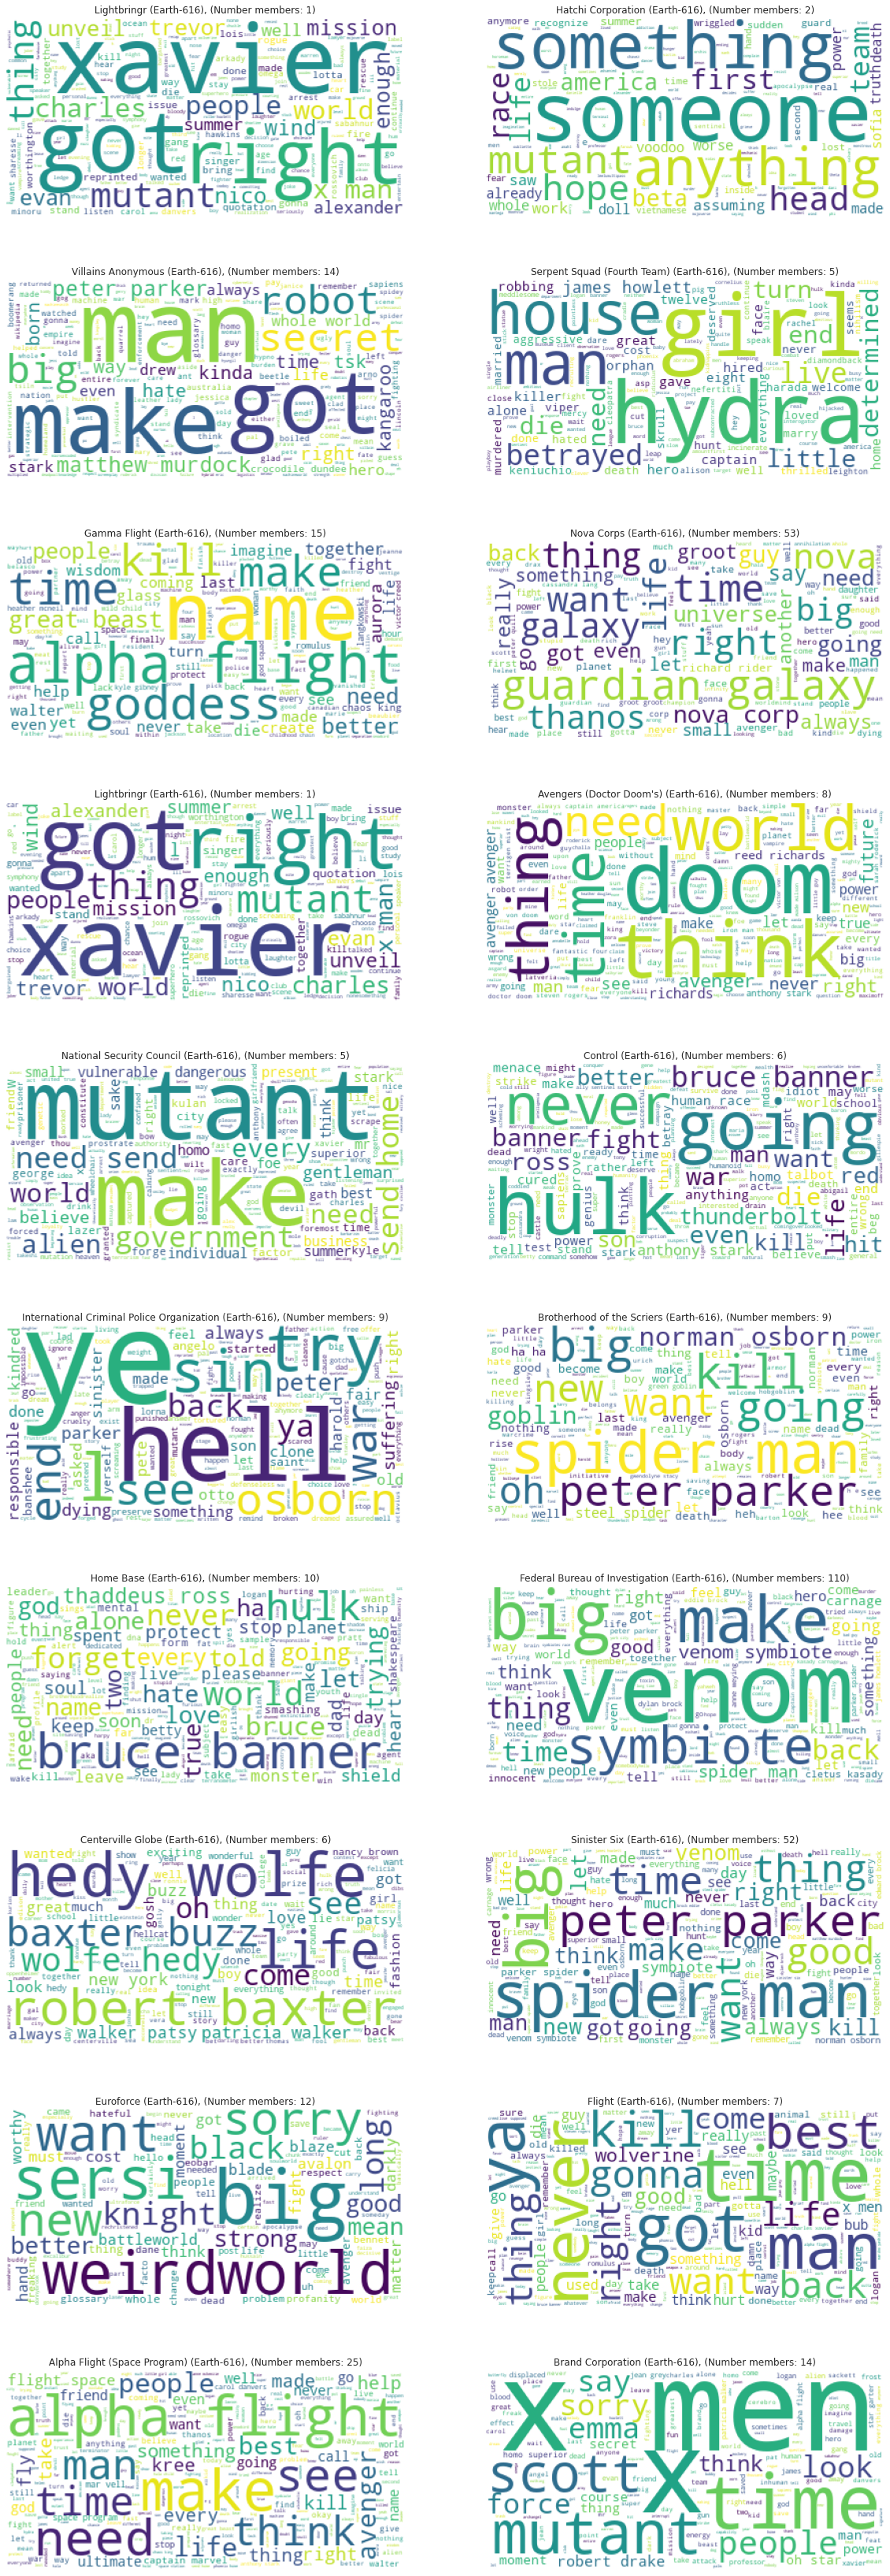

In [25]:
fig, axarr = plt.subplots(10, 2, figsize=(20, 60))

df_quotes = df[df["number_quotes"] > 10]

word_cloud = WordCloud(max_words=2000,
                       background_color="white"
                      )
additional_stop_words = ["earth", "know", "im", "b", "u"]

for i, ax in enumerate(axarr.flatten()):
  sample = df_quotes.sample()
  content = " ".join(word
                     for quote in sample.iloc[0, 5]
                     for word in quote if word not in additional_stop_words)
  ax.imshow(word_cloud.generate(content))
  ax.axis("off")
  ax.set_title(f"{sample.iloc[0, 0]}, (Number members: {sample.iloc[0, 2]})")

plt.show()

In [26]:
df

team_name  \
0                            Oracle Inc. (Earth-616)   
1                         Metal Mobsters (Earth-616)   
2      Knights of the Atomic Round Table (Earth-616)   
3                                             Yoruba   
4           Emissaries of Evil (Electro) (Earth-616)   
...                                              ...   
3046                       Junkyard Dogs (Earth-616)   
3047           S.H.I.E.L.D. Psi Division (Earth-616)   
3048                             Crusade (Earth-616)   
3049  Fraternity of Raptors (Warp World) (Earth-616)   
3050               Serpent Squad (Cobra) (Earth-616)   

                                                members  number_members  \
0     [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                    []               0   
2     [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                    []               0   
4     [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   
...                                                 ...             ...   
3046                  [Rashid Hammer Jones (Earth-616)]               1   
3047  [Agent Locke (Earth-616), Daniel Fricks (Earth...              10   
3048                           [Ezra Keith (Earth-616)]               1   
3049                                                 []               0   
3050  [Jordan Dixon (Earth-616), Klaus Voorhees (Ear...               3   

                                                 quotes  number_quotes  \
0     [Now I can take my father's place -- as an Inv...            169   
1                                                    []              0   
2     [There's only two things I ever managed to bel...            922   
3                                                    []              0   
4     [I have defeated the most deadly toros in a th...             26   
...                                                 ...            ...   
3046                                                 []              0   
3047  [What a team we shall make! With my brain, the...              4   
3048                                                 []              0   
3049                                                 []              0   
3050  [Ring around the '''collar''', [[Samuel Wilson...              7   

                                       processed_quotes  \
0     [[take, father, place, invader], [take, father...   
1                                                    []   
2     [[two, thing, ever, managed, believe, firstly,...   
3                                                    []   
4     [[defeated, deadly, toros, thousand, bull, fig...   
...                                                 ...   
3046                                                 []   
3047  [[team, shall, make, brain, secret, see, every...   
3048                                                 []   
3049                                                 []   
3050  [[ring, around, collar, samuel, wilson, earth,...   

                                                 tf-idf  
0     [(buring, 0.6338216477661611), (homeworld, 0.2...  
1                                                    []  
2     [(ugly, 0.8182761335554977), (popgun, 0.438099...  
3                                                    []  
4     [(justice, 0.11658860715734258), (later, 0.116...  
...                                                 ...  
3046                                                 []  
3047  [(together, 0.0075705808539942325), (strategic...  
3048                                                 []  
3049                                                 []  
3050  [(616, 0.08918924846181091), (dying, 0.1252762...  

[3051 rows x 7 columns]

In [53]:
def getLenMembersWiki(row):
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  regex_newline = r"\\n"
  regex_no_alpha = r"[^a-zA-Z ]"
  regex_aditional_space = r"\s\s+"
  textLen = []
  for member in row["members"]:
    filename= utils.generate_filename(member)
    try:
      with open("../data/character_content/"+filename+".json") as f:
        text = re.sub(regex_links, "", f.read())
        text = re.sub(regex_newline, " ", text)
        text = re.sub(regex_no_alpha, " ", text)
        text = re.sub(regex_aditional_space, " ", text)

        textLen.append(len(text.split(" ")))
    except:
      pass
  if len(textLen):
    return sum(textLen)/len(textLen)
  return 0
  
df["members_wiki_avg_len"] = df.progress_apply(getLenMembersWiki, axis=1)

df.head()

Getting quotes:   0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  number_members  \
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                 []               0   
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                 []               0   
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   

                                              quotes  number_quotes  \
0  [Now I can take my father's place -- as an Inv...            169   
1                                                 []              0   
2  [There's only two things I ever managed to bel...            922   
3                                                 []              0   
4  [I have defeated the most deadly toros in a th...             26   

                                    processed_quotes  \
0  [[take, father, place, invader], [take, father...   
1                                                 []   
2  [[two, thing, ever, managed, believe, firstly,...   
3                                                 []   
4  [[defeated, deadly, toros, thousand, bull, fig...   

                                              tf-idf  members_wiki_avg_len  
0  [(buring, 0.6338216477661611), (homeworld, 0.2...           2516.555556  
1                                                 []              0.000000  
2  [(ugly, 0.8182761335554977), (popgun, 0.438099...          12307.500000  
3                                                 []              0.000000  
4  [(justice, 0.11658860715734258), (later, 0.116...           2014.400000

In [56]:
df[df["members_wiki_avg_len"] > 0].sort_values("members_wiki_avg_len", ascending=False)

team_name  \
2105           Titans Three (Earth-616)   
2281         Magneto's Army (Earth-616)   
1987  X-Men Training Squads (Earth-616)   
2093          Team Deadpool (Earth-616)   
742                  Mighty (Earth-616)   
...                                 ...   
2055        Twisted Sisters (Earth-616)   
987                Creators (Earth-616)   
487           Lizard People (Earth-616)   
2553      Three-Who-Are-All (Earth-616)   
1306         Satan's Saints (Earth-616)   

                                                members  number_members  \
2105  [Bruce Banner (Earth-616), Namor McKenzie (Ear...               3   
2281                       [Max Eisenhardt (Earth-616)]               1   
1987                         [Laura Kinney (Earth-616)]               1   
2093                          [Wade Wilson (Earth-616)]               1   
742   [Anthony Stark (Earth-616), Carol Danvers (Ear...               9   
...                                                 ...             ...   
2055  [Coil (Earth-616), Gyre (Twisted Sisters) (Ear...               4   
987   [Cygni (Earth-616), Harken (Earth-616), Sirius...               3   
487                                [Zaurai (Earth-616)]               1   
2553                           [Cowled One (Earth-616)]               1   
1306   [Red-Bone (Earth-616), Rocky Rhodes (Earth-616)]               2   

                                                 quotes  number_quotes  \
2105  [The '''angrier''' I get the '''stronger''' I ...            450   
2281  [Tell everyone who will listen. Tell everyone ...             91   
1987  [I'm the '''last''' person who gets to lecture...             30   
2093  [It's an angel of God. My glorious Bea Arthur-...            287   
742   [There's only two things I ever managed to bel...           1941   
...                                                 ...            ...   
2055                                                 []              0   
987                                                  []              0   
487                                                  []              0   
2553                                                 []              0   
1306                                                 []              0   

                                       processed_quotes  \
2105  [[angrier, get, stronger, get, strongest, hulk...   
2281  [[tell, everyone, listen, tell, everyone, plea...   
1987  [[last, person, get, lecture, anyone, obsessiv...   
2093  [[angel, god, glorious, bea, arthur], [well, n...   
742   [[two, thing, ever, managed, believe, firstly,...   
...                                                 ...   
2055                                                 []   
987                                                  []   
487                                                  []   
2553                                                 []   
1306                                                 []   

                                                 tf-idf  members_wiki_avg_len  
2105  [(kind, 0.24998942612945915), (b, 1.0063060573...          18529.666667  
2281  [(forgotten, 0.1659874924329089), (inhomo, 0.1...          14572.000000  
1987  [(chemical, 0.10964690919019265), (proud, 0.13...          13920.000000  
2093  [(woke, 0.33108900234664507), (god, 0.18567860...          13425.000000  
742   [(kept, 0.32927334313593526), (think, 0.583399...          13113.000000  
...                                                 ...                   ...  
2055                                                 []             62.000000  
987                                                  []             62.000000  
487                                                  []             61.000000  
2553                                                 []             61.000000  
1306                                                 []             58.500000  

[2075 rows x 8 columns]

In [84]:
def getNumberLinksMembers(row):
  regex_links = r"(?:\{\{.*?\}\}|\[\[.*?\]\])"
  
  links = []
  for member in row["members"]:
    filename= utils.generate_filename(member)
    try:
      with open("../data/character_content/"+filename+".json") as f:
        link_char = re.findall(regex_links, f.read())

        links.append(len(link_char))
    except:
      pass
  if len(links):
    return sum(links)/len(links)
  return 0
  
df["members_avg_links"] = df.progress_apply(getNumberLinksMembers, axis=1)

df.head()

Getting quotes:   0%|          | 0/3051 [00:00<?, ?it/s]

team_name  \
0                        Oracle Inc. (Earth-616)   
1                     Metal Mobsters (Earth-616)   
2  Knights of the Atomic Round Table (Earth-616)   
3                                         Yoruba   
4       Emissaries of Evil (Electro) (Earth-616)   

                                             members  number_members  \
0  [Anita Savvy (Earth-616), Caleb Alexander (Ear...              10   
1                                                 []               0   
2  [Anthony Stark (Earth-616), Bruce Banner (Eart...               6   
3                                                 []               0   
4  [Manuel Eloganto (Earth-616), Maxwell Dillon (...               5   

                                              quotes  number_quotes  \
0  [Now I can take my father's place -- as an Inv...            169   
1                                                 []              0   
2  [There's only two things I ever managed to bel...            922   
3                                                 []              0   
4  [I have defeated the most deadly toros in a th...             26   

                                    processed_quotes  \
0  [[take, father, place, invader], [take, father...   
1                                                 []   
2  [[two, thing, ever, managed, believe, firstly,...   
3                                                 []   
4  [[defeated, deadly, toros, thousand, bull, fig...   

                                              tf-idf  members_wiki_avg_len  \
0  [(buring, 0.6338216477661611), (homeworld, 0.2...           2516.555556   
1                                                 []              0.000000   
2  [(ugly, 0.8182761335554977), (popgun, 0.438099...          12307.500000   
3                                                 []              0.000000   
4  [(justice, 0.11658860715734258), (later, 0.116...           2014.400000   

   members_avg_links  
0         127.777778  
1           0.000000  
2         806.166667  
3           0.000000  
4         103.200000

In [65]:
print("Corr members wiki len vs num members\t", df['members_wiki_avg_len'].corr(df['number_members']))
print("Corr members wiki len vs num quotes\t", df['members_wiki_avg_len'].corr(df['number_quotes']))
print("Corr num quotes vs num members\t\t", df['number_members'].corr(df['number_quotes']))

Corr members wiki len vs num members	 0.10119120054024913
Corr members wiki len vs num quotes	 0.5192634415041477
Corr num quotes vs num members		 0.479374263569197


In [72]:
df_sorted = df.sort_values("members_wiki_avg_len", ascending=False).reset_index()
df_sorted.head()

index                          team_name  \
0   2105           Titans Three (Earth-616)   
1   2281         Magneto's Army (Earth-616)   
2   1987  X-Men Training Squads (Earth-616)   
3   2093          Team Deadpool (Earth-616)   
4    742                 Mighty (Earth-616)   

                                             members  number_members  \
0  [Bruce Banner (Earth-616), Namor McKenzie (Ear...               3   
1                       [Max Eisenhardt (Earth-616)]               1   
2                         [Laura Kinney (Earth-616)]               1   
3                          [Wade Wilson (Earth-616)]               1   
4  [Anthony Stark (Earth-616), Carol Danvers (Ear...               9   

                                              quotes  number_quotes  \
0  [The '''angrier''' I get the '''stronger''' I ...            450   
1  [Tell everyone who will listen. Tell everyone ...             91   
2  [I'm the '''last''' person who gets to lecture...             30   
3  [It's an angel of God. My glorious Bea Arthur-...            287   
4  [There's only two things I ever managed to bel...           1941   

                                    processed_quotes  \
0  [[angrier, get, stronger, get, strongest, hulk...   
1  [[tell, everyone, listen, tell, everyone, plea...   
2  [[last, person, get, lecture, anyone, obsessiv...   
3  [[angel, god, glorious, bea, arthur], [well, n...   
4  [[two, thing, ever, managed, believe, firstly,...   

                                              tf-idf  members_wiki_avg_len  
0  [(kind, 0.24998942612945915), (b, 1.0063060573...          18529.666667  
1  [(forgotten, 0.1659874924329089), (inhomo, 0.1...          14572.000000  
2  [(chemical, 0.10964690919019265), (proud, 0.13...          13920.000000  
3  [(woke, 0.33108900234664507), (god, 0.18567860...          13425.000000  
4  [(kept, 0.32927334313593526), (think, 0.583399...          13113.000000

In [85]:
df_for_plots = df[["number_members", "number_quotes", "members_wiki_avg_len", "members_avg_links"]].copy()
df_for_plots =(df_for_plots-df_for_plots.min())/(df_for_plots.max()-df_for_plots.min())
df_for_plots.head()

number_members  number_quotes  members_wiki_avg_len  members_avg_links
0        0.015625       0.033545              0.135812           0.112646
1        0.000000       0.000000              0.000000           0.000000
2        0.009375       0.183009              0.664205           0.710696
3        0.000000       0.000000              0.000000           0.000000
4        0.007812       0.005161              0.108712           0.090979

<AxesSubplot:>

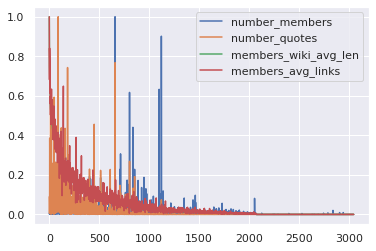

In [86]:
df_for_plots.sort_values("members_wiki_avg_len",
                         ascending=False).reset_index().plot(y=["number_members",
                                                                "number_quotes",
                                                                "members_wiki_avg_len",
                                                                "members_avg_links"])